In [61]:
# importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import f1_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


In [62]:
# reading the data
df = pd.read_csv("data/modelling_data.csv")

In [63]:
#
df.head()

,Category,SubCategory,Label,days_active,R,F,M,Loyalty,Avg Purchase Gap,add_to_cart_to_purchase_ratios,...,click_wishlist_page_to_purchase_ratios,user_path,cart_to_purchase_ratios_category,cart_to_purchase_ratios_subcategory,wishlist_to_purchase_ratios_category,wishlist_to_purchase_ratios_subcategory,click_wishlist_to_purchase_ratios_category,click_wishlist_to_purchase_ratios_subcategory,product_view_to_purchase_ratios_category,product_view_to_purchase_ratios_subcategory
0,Camera Accessories,Camera Bag,1,3,4.0,4.0,4.0,Platinum,184.0,1.0,...,2.0,others,0.300000,1.0,NaN,NaN,0.30,1.0,0.600000,NaN
1,Camera Accessories,Camera Lens,0,3,4.0,4.0,4.0,Platinum,184.0,1.0,...,2.0,others,0.300000,1.0,NaN,NaN,0.30,NaN,0.600000,1.000000
2,Men's Fashion,Shoes,0,3,3.0,1.0,3.0,Gold,NaN,1.0,...,NaN,search-->product_view-->read_reviews-->add_to_...,0.800000,1.0,8.000000,NaN,2.00,1.0,0.615385,0.500000
3,Mobile & Accessories,Aux Cable,1,5,4.0,4.0,1.0,Platinum,56.0,1.0,...,NaN,search-->product_view-->read_reviews-->add_to_...,0.933333,1.0,2.333333,NaN,1.75,NaN,0.538462,0.333333
4,Mobile & Accessories,USB Cord,0,5,4.0,4.0,1.0,Platinum,56.0,1.0,...,NaN,search-->product_view-->read_reviews-->add_to_...,0.933333,1.0,2.333333,NaN,1.75,NaN,0.538462,1.000000


In [64]:
df.head()

,Category,SubCategory,Label,days_active,R,F,M,Loyalty,Avg Purchase Gap,add_to_cart_to_purchase_ratios,...,click_wishlist_page_to_purchase_ratios,user_path,cart_to_purchase_ratios_category,cart_to_purchase_ratios_subcategory,wishlist_to_purchase_ratios_category,wishlist_to_purchase_ratios_subcategory,click_wishlist_to_purchase_ratios_category,click_wishlist_to_purchase_ratios_subcategory,product_view_to_purchase_ratios_category,product_view_to_purchase_ratios_subcategory
0,Camera Accessories,Camera Bag,1,3,4.0,4.0,4.0,Platinum,184.0,1.0,...,2.0,others,0.300000,1.0,NaN,NaN,0.30,1.0,0.600000,NaN
1,Camera Accessories,Camera Lens,0,3,4.0,4.0,4.0,Platinum,184.0,1.0,...,2.0,others,0.300000,1.0,NaN,NaN,0.30,NaN,0.600000,1.000000
2,Men's Fashion,Shoes,0,3,3.0,1.0,3.0,Gold,NaN,1.0,...,NaN,search-->product_view-->read_reviews-->add_to_...,0.800000,1.0,8.000000,NaN,2.00,1.0,0.615385,0.500000
3,Mobile & Accessories,Aux Cable,1,5,4.0,4.0,1.0,Platinum,56.0,1.0,...,NaN,search-->product_view-->read_reviews-->add_to_...,0.933333,1.0,2.333333,NaN,1.75,NaN,0.538462,0.333333
4,Mobile & Accessories,USB Cord,0,5,4.0,4.0,1.0,Platinum,56.0,1.0,...,NaN,search-->product_view-->read_reviews-->add_to_...,0.933333,1.0,2.333333,NaN,1.75,NaN,0.538462,1.000000


In [65]:
print(f"The shape of the final dataframe is {df.shape}")

The shape of the final dataframe is (264, 21)


In [66]:
#
df['Label'].value_counts()

Label
1    132
0    132
Name: count, dtype: int64

In [67]:
# checking the balance of data
df['Label'].value_counts()

Label
1    132
0    132
Name: count, dtype: int64

In [68]:
#
df.describe()

,Label,days_active,R,F,M,Avg Purchase Gap,add_to_cart_to_purchase_ratios,add_to_wishlist_to_purchase_ratios,click_wishlist_page_to_purchase_ratios,cart_to_purchase_ratios_category,cart_to_purchase_ratios_subcategory,wishlist_to_purchase_ratios_category,wishlist_to_purchase_ratios_subcategory,click_wishlist_to_purchase_ratios_category,click_wishlist_to_purchase_ratios_subcategory,product_view_to_purchase_ratios_category,product_view_to_purchase_ratios_subcategory
count,264.00000,264.000000,171.000000,171.000000,171.000000,56.000000,264.000000,33.000000,155.000000,264.000000,264.000000,117.000000,44.000000,238.000000,155.000000,248.000000,156.000000
mean,0.50000,1.727273,2.614035,1.982456,2.549708,101.375000,0.642677,1.502525,0.697849,0.707862,0.660669,3.587179,1.518939,1.138956,0.642473,0.792687,0.548123
std,0.50095,1.357088,1.118103,1.412023,1.122831,76.601225,0.519226,0.623082,0.753727,0.404709,0.496386,2.461527,1.021864,0.775275,0.749336,0.529491,0.466646
min,0.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.333333,0.000000,0.000000,0.000000,0.000000
25%,0.00000,1.000000,2.000000,1.000000,2.000000,36.000000,0.000000,1.000000,0.000000,0.500000,0.000000,2.000000,1.000000,0.636364,0.000000,0.500000,0.000000
50%,0.50000,1.000000,3.000000,1.000000,3.000000,91.000000,1.000000,2.000000,0.500000,0.714286,1.000000,2.500000,1.000000,1.000000,0.666667,0.777778,0.500000
75%,1.00000,2.000000,4.000000,4.000000,4.000000,177.250000,1.000000,2.000000,1.000000,0.933333,1.000000,4.500000,2.000000,1.750000,1.000000,1.000000,1.000000
max,1.00000,8.000000,4.000000,4.000000,4.000000,246.000000,3.000000,2.000000,2.000000,3.000000,2.000000,9.000000,4.000000,4.000000,4.000000,3.000000,1.500000


In [69]:
df.describe()

,Label,days_active,R,F,M,Avg Purchase Gap,add_to_cart_to_purchase_ratios,add_to_wishlist_to_purchase_ratios,click_wishlist_page_to_purchase_ratios,cart_to_purchase_ratios_category,cart_to_purchase_ratios_subcategory,wishlist_to_purchase_ratios_category,wishlist_to_purchase_ratios_subcategory,click_wishlist_to_purchase_ratios_category,click_wishlist_to_purchase_ratios_subcategory,product_view_to_purchase_ratios_category,product_view_to_purchase_ratios_subcategory
count,264.00000,264.000000,171.000000,171.000000,171.000000,56.000000,264.000000,33.000000,155.000000,264.000000,264.000000,117.000000,44.000000,238.000000,155.000000,248.000000,156.000000
mean,0.50000,1.727273,2.614035,1.982456,2.549708,101.375000,0.642677,1.502525,0.697849,0.707862,0.660669,3.587179,1.518939,1.138956,0.642473,0.792687,0.548123
std,0.50095,1.357088,1.118103,1.412023,1.122831,76.601225,0.519226,0.623082,0.753727,0.404709,0.496386,2.461527,1.021864,0.775275,0.749336,0.529491,0.466646
min,0.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.333333,0.000000,0.000000,0.000000,0.000000
25%,0.00000,1.000000,2.000000,1.000000,2.000000,36.000000,0.000000,1.000000,0.000000,0.500000,0.000000,2.000000,1.000000,0.636364,0.000000,0.500000,0.000000
50%,0.50000,1.000000,3.000000,1.000000,3.000000,91.000000,1.000000,2.000000,0.500000,0.714286,1.000000,2.500000,1.000000,1.000000,0.666667,0.777778,0.500000
75%,1.00000,2.000000,4.000000,4.000000,4.000000,177.250000,1.000000,2.000000,1.000000,0.933333,1.000000,4.500000,2.000000,1.750000,1.000000,1.000000,1.000000
max,1.00000,8.000000,4.000000,4.000000,4.000000,246.000000,3.000000,2.000000,2.000000,3.000000,2.000000,9.000000,4.000000,4.000000,4.000000,3.000000,1.500000


The Dataset is perfectly balanced

In [70]:
# checking the NaNs
df.isna().sum()

Category                                           0
SubCategory                                        0
Label                                              0
days_active                                        0
R                                                 93
F                                                 93
M                                                 93
Loyalty                                           93
Avg Purchase Gap                                 208
add_to_cart_to_purchase_ratios                     0
add_to_wishlist_to_purchase_ratios               231
click_wishlist_page_to_purchase_ratios           109
user_path                                          0
cart_to_purchase_ratios_category                   0
cart_to_purchase_ratios_subcategory                0
wishlist_to_purchase_ratios_category             147
wishlist_to_purchase_ratios_subcategory          220
click_wishlist_to_purchase_ratios_category        26
click_wishlist_to_purchase_ratios_subcategory 

#### Imputation

- For R,F,M Features impute NaN with 0 because for a new user the RFM values would be NaN
- For avg_purchase_gap impute NaN with -1 because for the users who bought only once won't have a purchase_gap value
- For rest of all features impute NaN with 0

## Model Building

#### Data Splitting

In [71]:
# splitting the features and target
y = df['Label']
x = df.drop(columns=['Label'])

# train test splitting
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.2, random_state=42)

In [72]:
# splitting the categorical columns and numerical columns
cat_cols = x_train.select_dtypes(["object"]).columns.tolist()
cat_df = x_train[cat_cols]

num_cols = x_train.select_dtypes(["int","float"]).columns.tolist()
num_df = x_train[num_cols]

print("Categorical Columns \n\n",cat_cols,"\n\n")
print("Numerical Columns \n\n",num_cols,"\n\n")

# checking the no of categories in each categorical column
for i in cat_cols:
    print(f"{i} column has {df[i].nunique()}")

Categorical Columns 

 ['Category', 'SubCategory', 'Loyalty', 'user_path'] 


Numerical Columns 

 ['days_active', 'R', 'F', 'M', 'Avg Purchase Gap', 'add_to_cart_to_purchase_ratios', 'add_to_wishlist_to_purchase_ratios', 'click_wishlist_page_to_purchase_ratios', 'cart_to_purchase_ratios_category', 'cart_to_purchase_ratios_subcategory', 'wishlist_to_purchase_ratios_category', 'wishlist_to_purchase_ratios_subcategory', 'click_wishlist_to_purchase_ratios_category', 'click_wishlist_to_purchase_ratios_subcategory', 'product_view_to_purchase_ratios_category', 'product_view_to_purchase_ratios_subcategory'] 


Category column has 89
SubCategory column has 232
Loyalty column has 4
user_path column has 11


#### Categorical Encoding Strategy


- The Category and SubCategory features has 89, 232 Categories respecively so if we do OHE it will increase the dimensionaltiy so lets encode this using TargetEncoding
- Loyalty and user_path has only few categories so lets encode them using OHE

#### Imputation 

Lets build a ColumnTransformer which imputes missing values according to the column

In [73]:
# defining a lists of cols to impute with -1 
cols_to_impute_with_minus_1 = ["Avg Purchase Gap"]

# defining a lists of cols to impute with 0
cols_to_impute_with_0 = ['days_active', 'R', 'F', 'M', 'add_to_cart_to_purchase_ratios', 'add_to_wishlist_to_purchase_ratios', 'click_wishlist_page_to_purchase_ratios', 'cart_to_purchase_ratios_category', 'cart_to_purchase_ratios_subcategory', 'wishlist_to_purchase_ratios_category', 'wishlist_to_purchase_ratios_subcategory', 'click_wishlist_to_purchase_ratios_category', 'click_wishlist_to_purchase_ratios_subcategory', 'product_view_to_purchase_ratios_category', 'product_view_to_purchase_ratios_subcategory'] 

# definfing list of categorical cols to do OHE
ohe_cols = ["Loyalty","user_path"]

# definfing list of categorical cols to do Target encoding
target_encod_cols = ['Category', 'SubCategory']

In [74]:
# defining the imputer obj
imputer = ColumnTransformer([
                            ('imputer_0', SimpleImputer(strategy='constant', fill_value=0), cols_to_impute_with_0),
                            ('imputer_minus_1', SimpleImputer(strategy='constant', fill_value=-1), cols_to_impute_with_minus_1),
                            ('imputer_categorical', SimpleImputer(strategy='most_frequent'), cat_cols),
                            ])
imputer.set_output(transform="pandas")

ColumnTransformer(transformers=[('imputer_0',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['days_active', 'R', 'F', 'M',
                                  'add_to_cart_to_purchase_ratios',
                                  'add_to_wishlist_to_purchase_ratios',
                                  'click_wishlist_page_to_purchase_ratios',
                                  'cart_to_purchase_ratios_category',
                                  'cart_to_purchase_ratios_subcategory',
                                  'wishlist_to_purchase_ratios_category',
                                  'wishli...
                                  'click_wishlist_to_purchase_ratios_category',
                                  'click_wishlist_to_purchase_ratios_subcategory',
                                  'product_view_to_purchase_ratios_category',
                                  'product_view_to_purchase_ratios_subcategory']),
                                ('imputer_minus_1',
                                 SimpleImputer(fill_value=-1,
                                               strategy='constant'),
                                 ['Avg Purchase Gap']),
                                ('imputer_categorical',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['Category', 'SubCategory', 'Loyalty',
                                  'user_path'])])

#### Encoding

In [75]:
# getting the name of the first operation of imputer (ColumnTransformer) coz this name will be added as a prefix for all columns of the resulting df by imputer object
numerical_prefix = imputer.transformers[0][0]+"__"
purchase_prefix =  imputer.transformers[1][0]+"__"
categorical_prefix = imputer.transformers[2][0]+"__"

# prefixing the cols 
prefixed_ohe_cols = [categorical_prefix + col for col in ohe_cols ]
prefixed_target_encod_cols = [categorical_prefix + col for col in target_encod_cols]

prefixed_num_cols = [numerical_prefix + col for col in num_cols ]
# replacing the imputer_categorical__days_active imputer_minus_1__days_active
prefixed_num_cols = [f"{purchase_prefix}Avg Purchase Gap" if i == f"{numerical_prefix}Avg Purchase Gap" else i for i in prefixed_num_cols]

In [76]:
# definfing the encoder for categorical and numerical cols
encoder = ColumnTransformer([('scaler_numeric', StandardScaler(), prefixed_num_cols),
                             ('ohe_encoder', OneHotEncoder(sparse=False), prefixed_ohe_cols),
                             ('target_encoders', TargetEncoder(), prefixed_target_encod_cols)
                            ])
encoder.set_output(transform="pandas")

ColumnTransformer(transformers=[('scaler_numeric', StandardScaler(),
                                 ['imputer_0__days_active', 'imputer_0__R',
                                  'imputer_0__F', 'imputer_0__M',
                                  'imputer_minus_1__Avg Purchase Gap',
                                  'imputer_0__add_to_cart_to_purchase_ratios',
                                  'imputer_0__add_to_wishlist_to_purchase_ratios',
                                  'imputer_0__click_wishlist_page_to_purchase_ratios',
                                  'imputer_0__cart_to_purchase_ratio...
                                  'imputer_0__click_wishlist_to_purchase_ratios_subcategory',
                                  'imputer_0__product_view_to_purchase_ratios_category',
                                  'imputer_0__product_view_to_purchase_ratios_subcategory']),
                                ('ohe_encoder', OneHotEncoder(sparse=False),
                                 ['imputer_categorical__Loyalty',
                                  'imputer_categorical__user_path']),
                                ('target_encoders', TargetEncoder(),
                                 ['imputer_categorical__Category',
                                  'imputer_categorical__SubCategory'])])

#### Preprocessor pipeline

In [77]:
# creating a pipeline which consists of imputer followed by encoder
preprocessor = Pipeline([ ('imputer', imputer),
                          ('encoder',encoder)
                        ])
preprocessor.set_output(transform="pandas")

Pipeline(steps=[('imputer',
                 ColumnTransformer(transformers=[('imputer_0',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['days_active', 'R', 'F', 'M',
                                                   'add_to_cart_to_purchase_ratios',
                                                   'add_to_wishlist_to_purchase_ratios',
                                                   'click_wishlist_page_to_purchase_ratios',
                                                   'cart_to_purchase_ratios_category',
                                                   'cart_to_purchase_ratios_subcategory',
                                                   'wishlist_to_purcha...
                                                   'imputer_0__click_wishlist_to_purchase_ratios_subcategory',
                                                   'imputer_0__product_view_to_purchase_ratios_category',
                                                   'imputer_0__product_view_to_purchase_ratios_subcategory']),
                                                 ('ohe_encoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['imputer_categorical__Loyalty',
                                                   'imputer_categorical__user_path']),
                                                 ('target_encoders',
                                                  TargetEncoder(),
                                                  ['imputer_categorical__Category',
                                                   'imputer_categorical__SubCategory'])]))])

In [78]:
# applying the preprocessor pipeline to the x_train and x_test
x_train = preprocessor.fit_transform(x_train,y_train)
x_test  = preprocessor.transform(x_test)

C:\Users\Pradyu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Training

In [79]:
x_train.head()

,scaler_numeric__imputer_0__days_active,scaler_numeric__imputer_0__R,scaler_numeric__imputer_0__F,scaler_numeric__imputer_0__M,scaler_numeric__imputer_minus_1__Avg Purchase Gap,scaler_numeric__imputer_0__add_to_cart_to_purchase_ratios,scaler_numeric__imputer_0__add_to_wishlist_to_purchase_ratios,scaler_numeric__imputer_0__click_wishlist_page_to_purchase_ratios,scaler_numeric__imputer_0__cart_to_purchase_ratios_category,scaler_numeric__imputer_0__cart_to_purchase_ratios_subcategory,...,ohe_encoder__imputer_categorical__user_path_product_view-->read_reviews-->add_to_cart,ohe_encoder__imputer_categorical__user_path_product_view-->read_reviews-->click_wishlist_page-->add_to_cart,ohe_encoder__imputer_categorical__user_path_read_reviews-->add_to_cart,ohe_encoder__imputer_categorical__user_path_read_reviews-->click_wishlist_page-->add_to_cart,ohe_encoder__imputer_categorical__user_path_read_reviews-->product_view-->click_wishlist_page-->add_to_cart,ohe_encoder__imputer_categorical__user_path_search-->product_view-->click_wishlist_page-->add_to_cart,ohe_encoder__imputer_categorical__user_path_search-->product_view-->read_reviews-->add_to_cart,ohe_encoder__imputer_categorical__user_path_search-->read_reviews-->click_wishlist_page-->add_to_cart,target_encoders__imputer_categorical__Category,target_encoders__imputer_categorical__SubCategory
144,-0.522239,0.240021,-0.149621,0.295332,-0.405253,0.707079,-0.317411,-0.580489,0.746166,0.722845,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.550625,0.550625
73,2.517550,-0.401047,-0.149621,1.621183,-0.405253,-0.225381,1.706983,1.006765,0.746166,0.722845,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.516186,0.420516
78,0.237709,0.881089,-0.149621,1.621183,-0.405253,0.707079,-0.317411,-0.580489,-1.102147,0.722845,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444203,0.550625
252,-0.522239,-1.042115,-0.835924,-1.030520,-0.405253,-1.157842,-0.317411,-0.580489,0.746166,-1.286204,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.511719,0.420516
182,-0.522239,0.881089,-0.149621,-0.367594,-0.405253,0.707079,-0.317411,1.006765,-0.133983,0.722845,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.488555,0.550625


In [80]:
x_train.describe()

,scaler_numeric__imputer_0__days_active,scaler_numeric__imputer_0__R,scaler_numeric__imputer_0__F,scaler_numeric__imputer_0__M,scaler_numeric__imputer_minus_1__Avg Purchase Gap,scaler_numeric__imputer_0__add_to_cart_to_purchase_ratios,scaler_numeric__imputer_0__add_to_wishlist_to_purchase_ratios,scaler_numeric__imputer_0__click_wishlist_page_to_purchase_ratios,scaler_numeric__imputer_0__cart_to_purchase_ratios_category,scaler_numeric__imputer_0__cart_to_purchase_ratios_subcategory,...,ohe_encoder__imputer_categorical__user_path_product_view-->read_reviews-->add_to_cart,ohe_encoder__imputer_categorical__user_path_product_view-->read_reviews-->click_wishlist_page-->add_to_cart,ohe_encoder__imputer_categorical__user_path_read_reviews-->add_to_cart,ohe_encoder__imputer_categorical__user_path_read_reviews-->click_wishlist_page-->add_to_cart,ohe_encoder__imputer_categorical__user_path_read_reviews-->product_view-->click_wishlist_page-->add_to_cart,ohe_encoder__imputer_categorical__user_path_search-->product_view-->click_wishlist_page-->add_to_cart,ohe_encoder__imputer_categorical__user_path_search-->product_view-->read_reviews-->add_to_cart,ohe_encoder__imputer_categorical__user_path_search-->read_reviews-->click_wishlist_page-->add_to_cart,target_encoders__imputer_categorical__Category,target_encoders__imputer_categorical__SubCategory
count,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,...,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,9.471097e-18,6.735002e-17,-9.681566e-17,-4.419845e-17,-2.525626e-17,2.946563e-17,-2.946563e-17,7.576878e-17,1.136532e-16,-8.839690e-17,...,0.028436,0.132701,0.042654,0.094787,0.033175,0.023697,0.137441,0.028436,0.481990,0.482447
std,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,...,0.166610,0.340059,0.202556,0.293617,0.179520,0.152464,0.345131,0.166610,0.048721,0.062136
min,-5.222386e-01,-1.042115e+00,-8.359238e-01,-1.030520e+00,-4.052526e-01,-1.157842e+00,-3.174109e-01,-5.804886e-01,-1.718252e+00,-1.286204e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.402208,0.408742
25%,-5.222386e-01,-1.042115e+00,-8.359238e-01,-1.030520e+00,-4.052526e-01,-1.157842e+00,-3.174109e-01,-5.804886e-01,-6.400688e-01,-1.286204e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.420516,0.420516
50%,-5.222386e-01,-4.010473e-01,-1.496206e-01,-3.675939e-01,-4.052526e-01,7.070792e-01,-3.174109e-01,-5.804886e-01,6.840971e-03,7.228452e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.487252,0.485765
75%,2.377086e-01,8.810887e-01,-1.496206e-01,9.582576e-01,-4.052526e-01,7.070792e-01,-3.174109e-01,1.006765e+00,5.818718e-01,7.228452e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.514768,0.550625
max,4.797392e+00,1.522157e+00,1.909289e+00,1.621183e+00,3.850349e+00,4.436922e+00,3.731377e+00,2.594019e+00,5.675002e+00,2.731894e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.556691,0.556691


In [81]:
models={ 'Logistic Regression': LogisticRegression(),
                     'Decision Tree': DecisionTreeClassifier(),
                     'KNN': KNeighborsClassifier(),
                     'RF':RandomForestClassifier(),
                     'GBDT':GradientBoostingClassifier(),
                     'XGBoost': XGBClassifier()
                     }

The f1 score of Logistic Regression is 0.8787878787878789



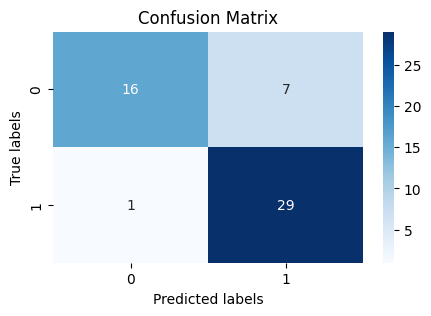

The f1 score of Decision Tree is 0.8518518518518519



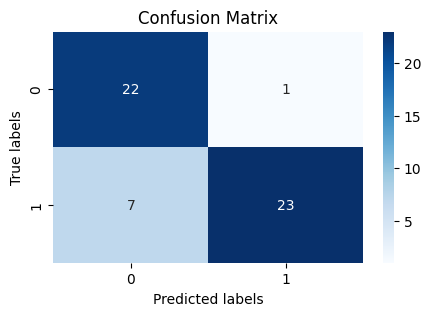

The f1 score of KNN is 0.8656716417910447



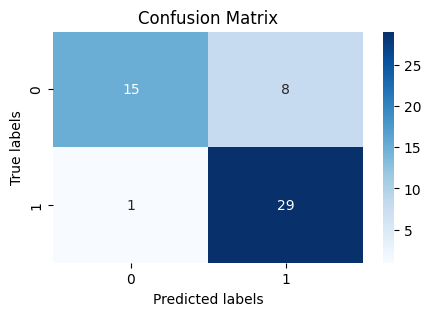

The f1 score of RF is 0.8307692307692307



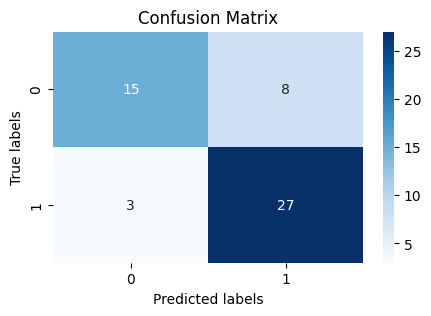

The f1 score of GBDT is 0.8771929824561403



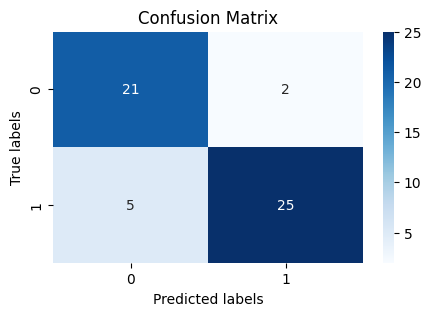

The f1 score of XGBoost is 0.8524590163934426



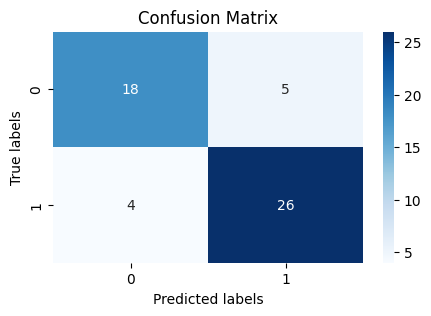

In [82]:
for i,model in models.items():
    # fitting the model
    model.fit(x_train,y_train)
    #Predict on test data
    y_test_pred = model.predict(x_test)
    # printing the f1_score
    print(f"The f1 score of {i} is {f1_score(y_test,y_test_pred)}\n")
    # compting the conf matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    # Plotting the confusion matrix as a heatmap
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

-  If my model predicts 0 for a label of 1 it means it predicts that the user won't buy within the next 2 hrs which means we would spend for a person who anayway going to end up purchasing this wastes our money so the FN rate should be very minimal
-   If my model predicts 1 for a label of 0 it means it predicts that the user would buy within the next 2 hrs which means we would miss him out for sending offers and coupons therfore we are missing our targets so the FP rate should also be minimal

Business Objective : Its okay to miss some people but we should not waste money on pursuing a wrong customer so the FN rate should be minimized heavily compared to FP rate

From the above confusion matrix it is observed that RF minimizes both FN and FP to a greater extent so lets choose it for training

In [83]:
# defining the logistic regression model
model = LogisticRegression()

# fitting the model
model.fit(x_train,y_train)

LogisticRegression()

In [84]:
# Predict on test data
y_pred = model.predict(x_test)

In [85]:
f1_score(y_test,y_pred)

0.8787878787878789

In [86]:
from sklearn.metrics import confusion_matrix

# Assuming y_test contains the true labels and y_pred contains the predicted labels
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
x_train.shape

Confusion Matrix:
[[16  7]
 [ 1 29]]


(211, 33)

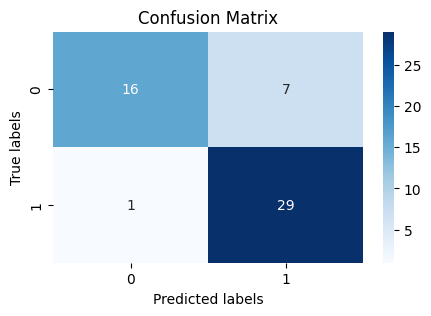

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
